In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
import torch.nn.functional as F #pytorch神经网络函数库，如激活函数和损失函数
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [2]:
seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        
        self.u = torch.tensor(u).float().to(device)
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)
        return loss
      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式


        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        #使用SGD优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='SGD'):
            u_pred = self.net_u(self.x_u, self.t_u)
            f_pred = self.net_f(self.x_f, self.t_f)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

            # Backward and optimize
            self.optimizer_SGD.zero_grad()
            loss.backward()
            self.optimizer_SGD.step()

            #record the loss value
            self.loss_value.append(loss)

            # record the test error
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)


            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights



        # #使用Adam优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='Adam'):
        #     u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
        #     # Backward and optimize
        #     self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        #     loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        #     self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
        #     #record the loss value
        #     self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     # batch_size = 100  # 设置批次大小
        #     # n = len(self.x_star)
        #     # u_real_pred = []
        #     # for i in range(0, n, batch_size):
        #     #     x_star_batch = self.x_star[i:i+batch_size]
        #     #     t_star_batch = self.t_star[i:i+batch_size]
        #     #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
        #     #     u_real_pred.append(u_real_pred_batch)
        #     # u_real_pred = torch.cat(u_real_pred)


        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)

        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [34]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def quasirandom(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [35]:
nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 1000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)

# #生成配位点训练基础数据
# X_f_train = quasirandom(N_f, "LHS")  #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，表示生产的样本有两个特征，共N_f个样本数量，所以返回的是一个形状为（N_f，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本X_f_train。

# X_f_train = np.vstack((X_f_train, X_u_train)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train


In [36]:
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500

trainloss = [] #创建一个空列表，用于存储训练损失值
testerror = [] #创建一个空列表，用于存储测试误差值
times = [] #创建一个空列表，用于存储训练时间
# 调用quasirandom函数生成配位点
X_f_train = quasirandom(N_f, "Grid")

# X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(nIter,nIterLBFGS)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))
times.append(elapsed) #将训练时间添加到times列表中


#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred, f_pred = model.predict(X_star)
#计算误差（基于2范数）        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

print('Error u of Random sampling: %e' % (error_u)) #打印误差               


#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())

testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

LBFGS: 100%|██████████| 500/500 [00:04<00:00, 105.34it/s]


Training time: 459.9036
Error u of Random sampling: 1.007639e+00


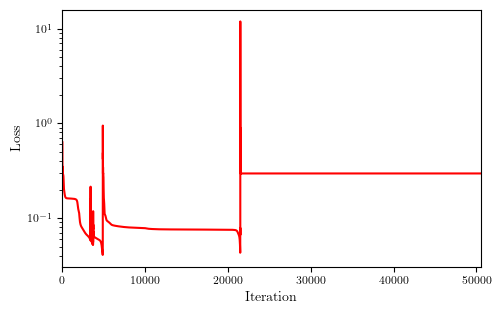

In [37]:
#打印误差随迭代次数的变化
# print(trainloss)
# print(trainloss.shape)
indices=list(range(len(trainloss[0])))
plt.figure()
plt.plot(indices,trainloss[0],color='red')
# plt.plot(indices[nIter:],trainloss[0][nIter:],color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlim([0,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.2]) # 设置y轴的范围
plt.show()

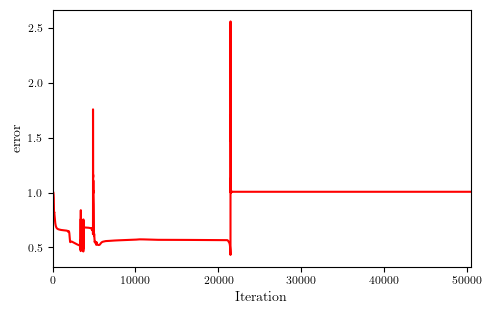

In [38]:
#打印误差随迭代次数的变化
# print(trainloss)
# print(trainloss.shape)
indices=list(range(len(testerror[0])))
plt.figure()
plt.plot(indices,testerror[0],color='red')
# plt.plot(indices[nIter:],trainloss[0][nIter:],color='blue')
plt.xlabel('Iteration')
plt.ylabel('error')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlim([0,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.2]) # 设置y轴的范围
plt.show()

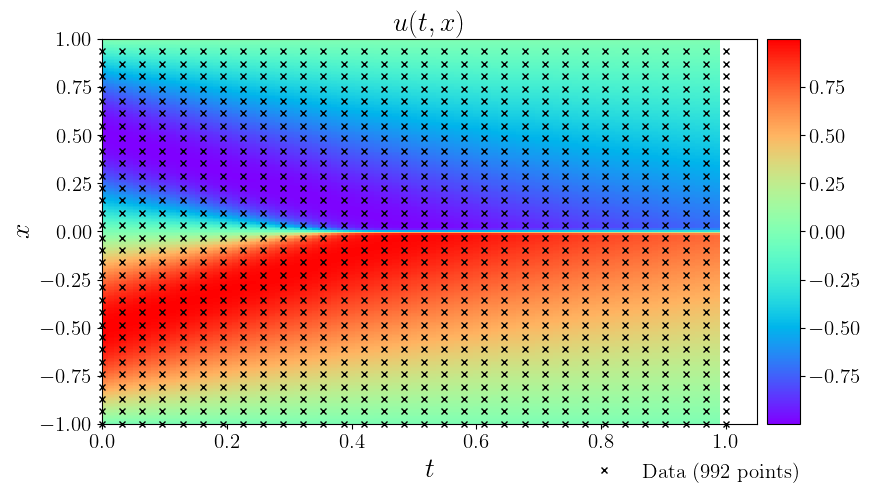

In [39]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [40]:
#chaos-based RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中混沌度最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = quasirandom(N_f_1, "Grid")


#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代
    N_f_new = 100 #重新采样100个点
    # 生成新的X_f_train数据
    X_f_train_new = quasirandom(N_f_new, "Grid")

    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(distances, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并


    


    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    

    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500次
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 127.00it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 126.14it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 127.04it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 127.73it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 128.42it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 125.88it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 128.42it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 127.38it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 128.15it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 127.34it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 129.36it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 129.45it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████

Training time: 434.4982
Error u: 7.697411e-01


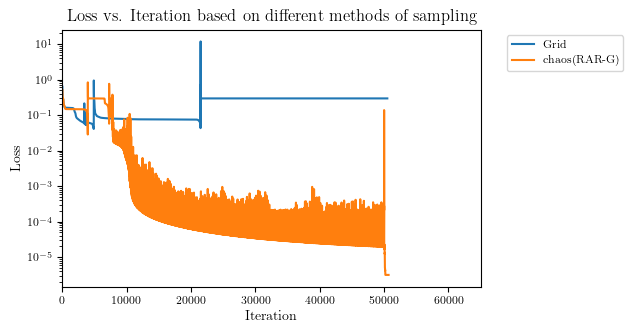

In [42]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

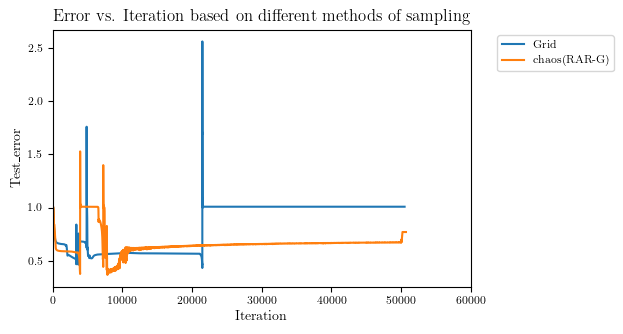

In [43]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

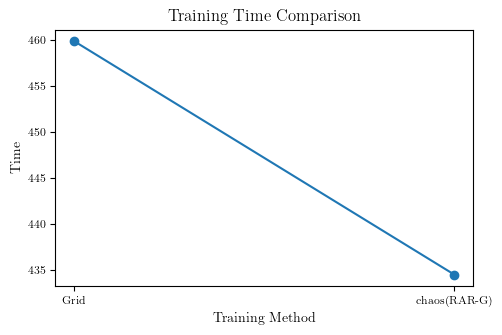

In [44]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

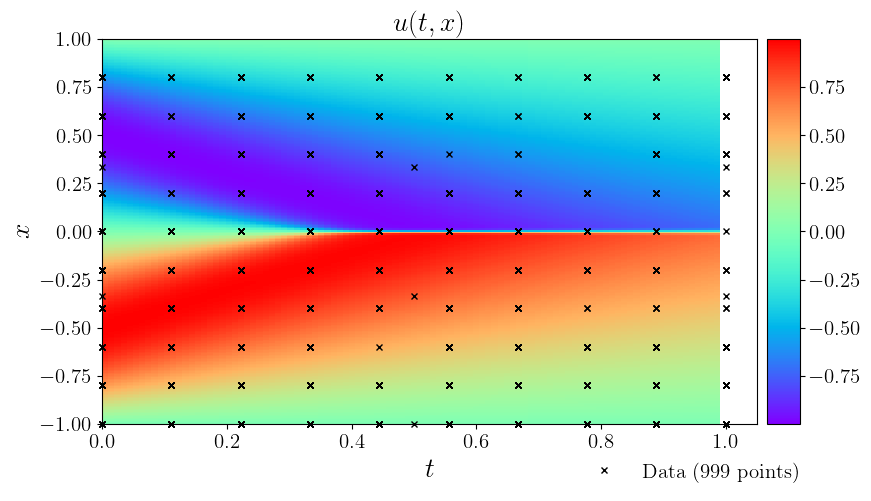

In [45]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [46]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


#先训练500次
#采样配位点10个
N_f_1 = 10

X_f_train = quasirandom(N_f_1, "Grid")

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代
    N_f_new = 100 #重新采样100个点
    # 生成新的X_f_train数据

    X_f_train_new = quasirandom(N_f_new, "Grid")

    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(abs_residual, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并



    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 142.19it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 133.17it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 141.46it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 143.46it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 139.76it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 133.96it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 141.00it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 141.96it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 140.49it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 138.32it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 138.63it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 141.07it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████

Training time: 391.8804
Error u: 5.133554e-01


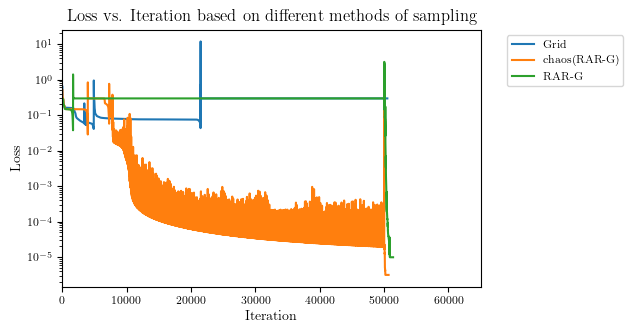

In [48]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

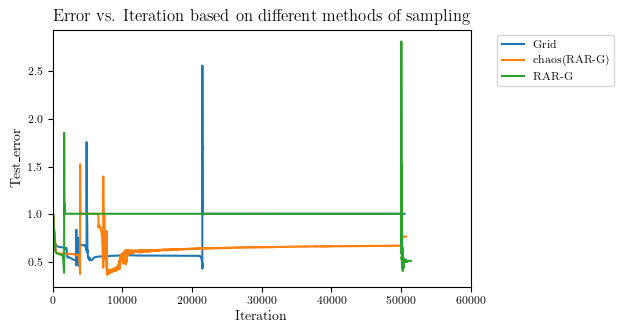

In [49]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

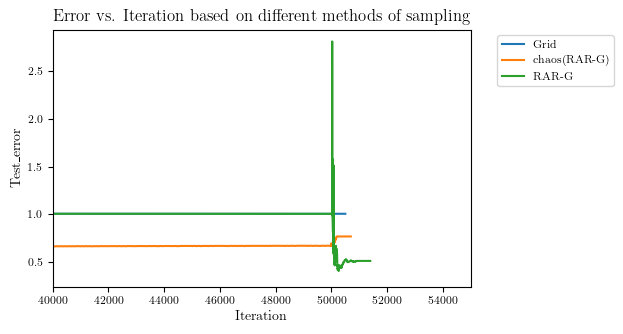

In [50]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([40000,55000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

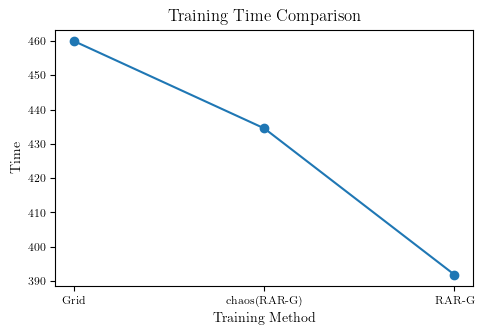

In [51]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

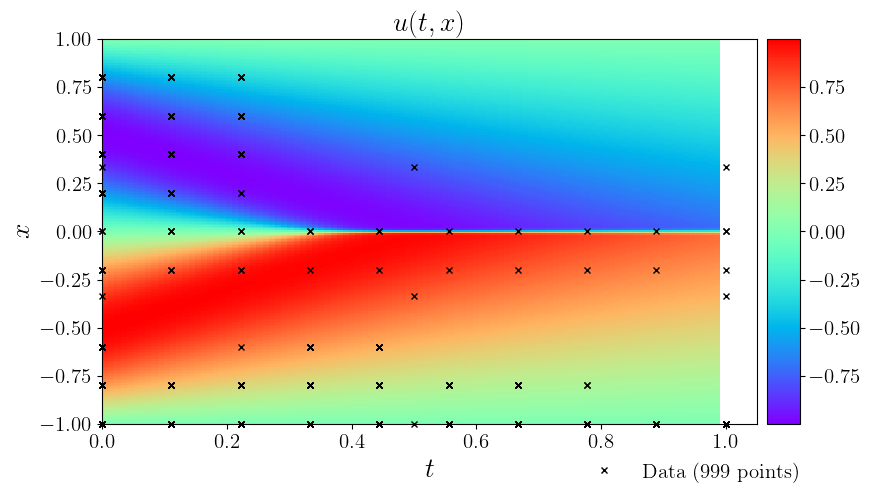

In [52]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [53]:
#fuheRAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中混沌度最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次

resampled_points = [] #初始化一个列表，用于存储所有的配位点

num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = quasirandom(N_f_1, "Grid")


#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代
    N_f_new = 100 #重新采样100个点
    # 生成新的X_f_train数据
    X_f_train_new = quasirandom(N_f_new, "Grid")

    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()


    # 对distances进行归一化
    distances = distances / np.linalg.norm(distances)

    # 对abs_residual进行归一化
    abs_residual = abs_residual / np.linalg.norm(abs_residual)

    # 计算信息量
    xinxi = distances + abs_residual


    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并






    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中





    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 134.76it/s]
LBFGS: 0it [00:00, ?it/s]
C:\Users\lcy\AppData\Local\Temp\ipykernel_692072\1207132593.py:82: RuntimeWarning: invalid value encountered in divide
  distances = distances / np.linalg.norm(distances)
SGD: 100%|██████████| 500/500 [00:03<00:00, 130.96it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 133.18it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 137.58it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 139.63it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 128.55it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 128.50it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 136.91it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 139.34it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 132.44it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%

Training time: 408.8064
Error u: 7.319314e-01


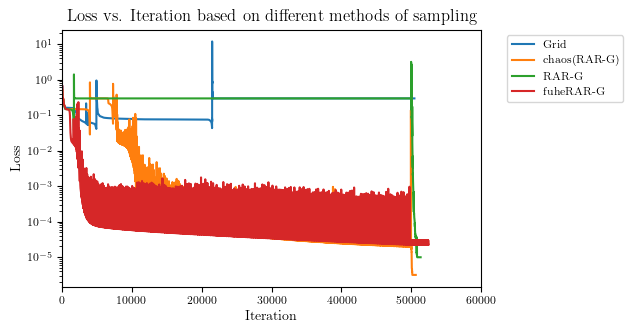

In [54]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G","fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlim([0,60000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

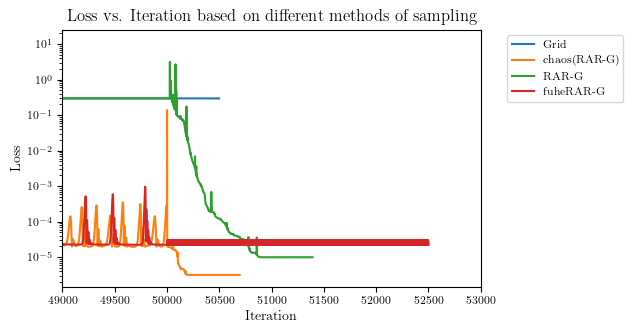

In [56]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G","fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlim([49000,53000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

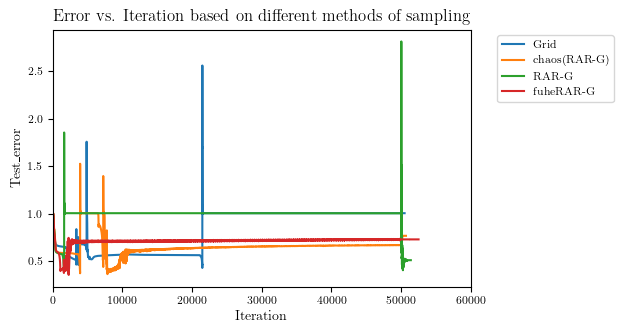

In [57]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G","fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

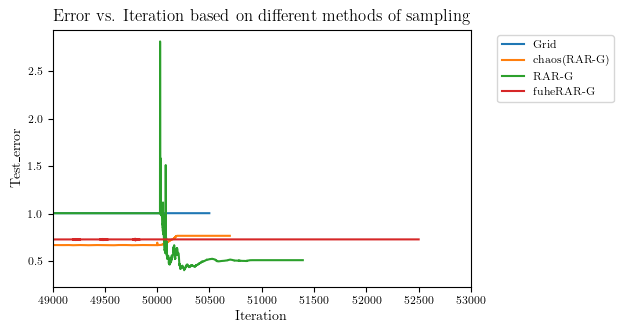

In [58]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G","fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([49000,53000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

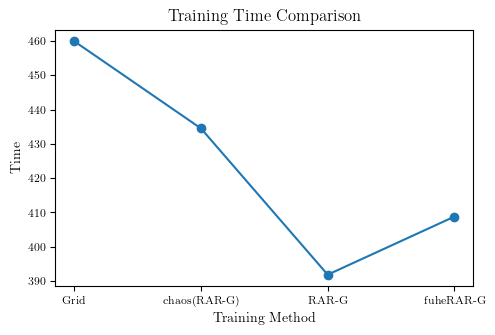

In [59]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

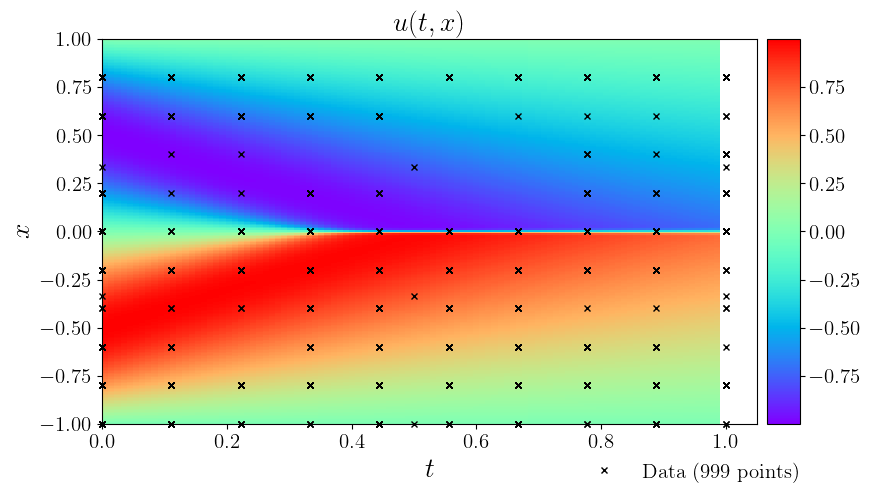

In [60]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [63]:
#每次选一个的chaos-based RAR-G方法，对1000个点，先选择10个点训练500次，然后每50次迭代重采样10个点，选出其中混沌度最大的1个点添加到训练点中；最后总共有1000个点，共训练50000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = quasirandom(N_f_1, "Grid")

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每50次迭代重采样一次10个点，并选出其中残差最大的1个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 50): #每500次迭代
    N_f_new = 10 #重新采样10个点
    # 生成新的X_f_train数据

    X_f_train_new = quasirandom(N_f_new, "Grid")

    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(distances, -1)[-1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并


    


    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    

    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练50次
    model.train(50,0)

model.train(0,500) #使用LBFGS训练500次
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中

#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 144.58it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 135.10it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 137.33it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 135.47it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 143.50it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 136.58it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 146.59it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 143.03it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 143.85it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 145.95it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 134.56it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 141.61it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:

Training time: 478.8472
Error u: 1.007640e+00


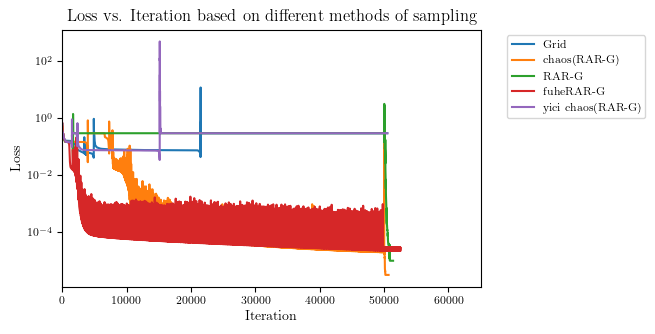

In [64]:
# 定义图例的标签
labels = ["Grid", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

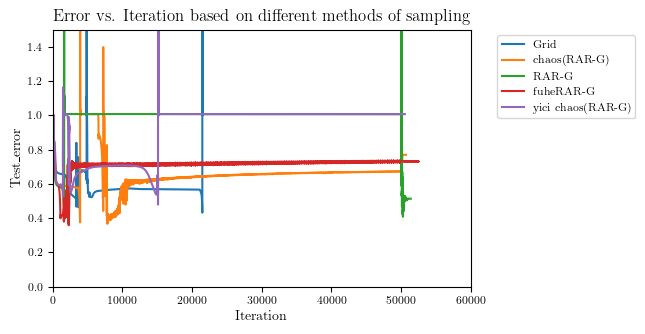

In [66]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围
plt.ylim([0,1.5]) # 设置y轴的范围
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

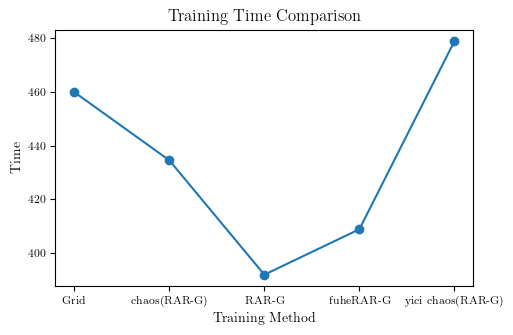

In [67]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

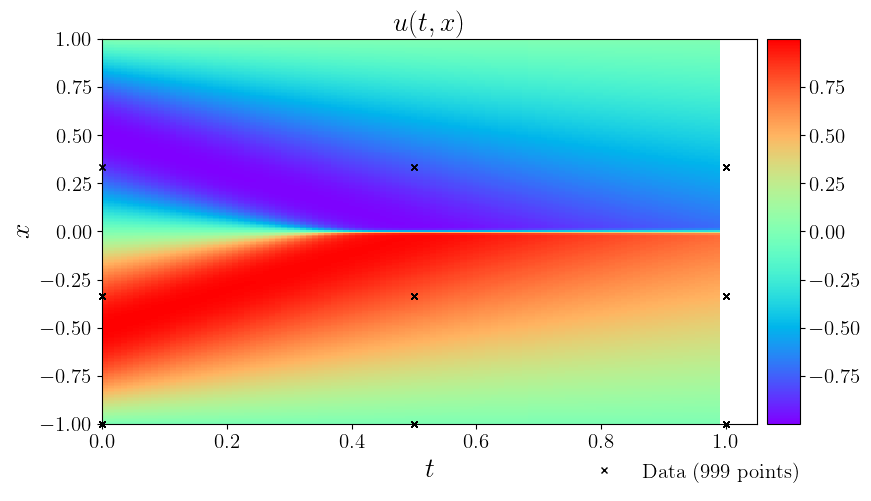

In [68]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

[[-1.          0.        ]
 [-0.33333333  0.        ]
 [ 0.33333333  0.        ]
 ...
 [ 0.33333333  1.        ]
 [ 0.33333333  1.        ]
 [ 0.33333333  1.        ]]


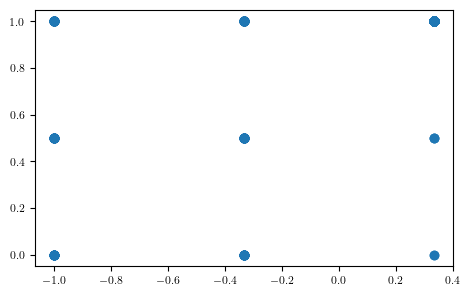

In [70]:

print(X_f_train)
# 假设points是你的数据点
# points = np.array([[x1, y1], [x2, y2], ..., [x1000, y1000]])

# 提取x和y坐标
x_coords = X_f_train[:, 0]
y_coords = X_f_train[:, 1]

# 使用scatter函数绘制散点图
plt.scatter(x_coords, y_coords)

# 显示图形
plt.show()

In [71]:
#每次选一个的RAR-G方法，对1000个点，先选择10个点训练500次，然后每50次迭代重采样10个点，选出其中残差最大的1个点添加到训练点中；最后总共有1000个点，共训练10000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = quasirandom(N_f_1, "Grid")

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 50): #每500次迭代
    N_f_new = 10 #重新采样10个点
    # 生成新的X_f_train数据
    X_f_train_new = quasirandom(N_f_new, "Grid")

    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(abs_residual, -1)[-1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并



    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(50,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 143.50it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 131.55it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 132.07it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 129.58it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 136.31it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 138.47it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 141.66it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 134.74it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 134.78it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 135.47it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 134.92it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 123.73it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:

Training time: 413.0551
Error u: 8.029479e-01


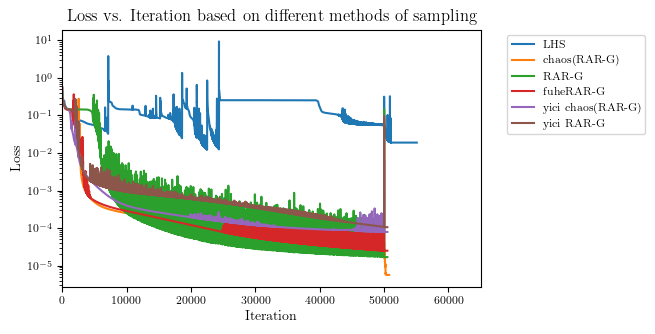

In [33]:
# 定义图例的标签
labels = ["LHS", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)", "yici RAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

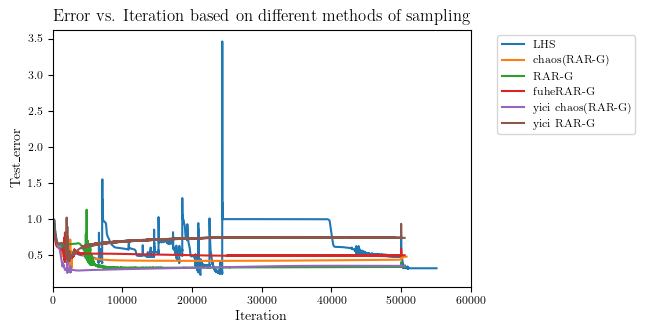

In [34]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

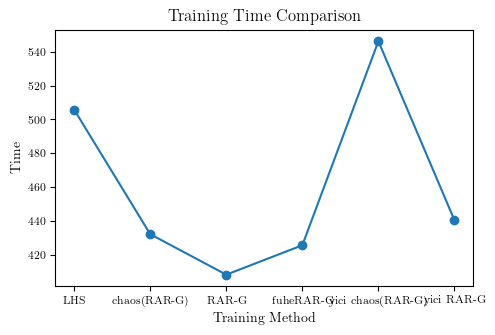

In [35]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

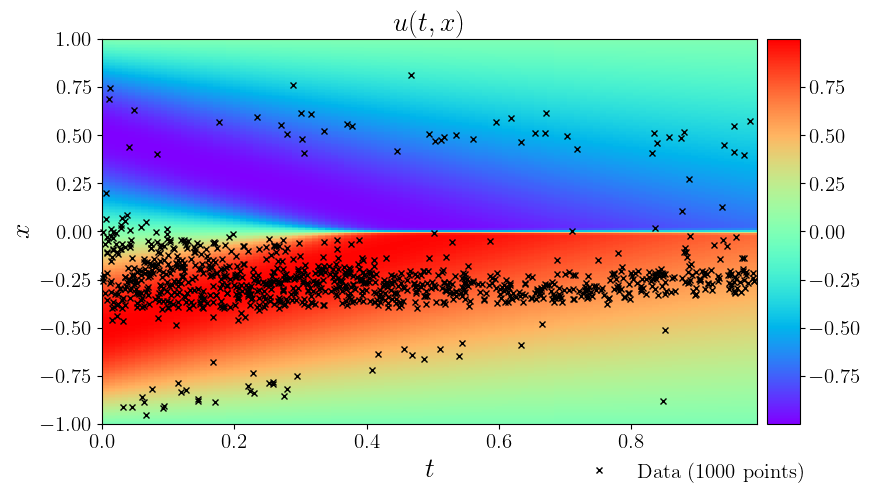

In [36]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [37]:
#每次选一个的fuheRAR-G方法，对1000个点，先选择10个点训练500次，然后每50次迭代重采样10个点，选出其中混沌度最大的1个点添加到训练点中；最后总共有1000个点，共训练50000次

resampled_points = [] #初始化一个列表，用于存储所有的配位点

num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = lb + (ub-lb)*lhs(2, N_f_1)

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每50次迭代重采样一次10个点，并选出其中残差最大的1个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 50): #每500次迭代
    N_f_new = 10 #重新采样10个点
    # 生成新的X_f_train数据
    X_f_train_new = lb + (ub-lb)*lhs(2, N_f_new)

    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()


    # 对distances进行归一化
    distances = distances / np.linalg.norm(distances)

    # 对abs_residual进行归一化
    abs_residual = abs_residual / np.linalg.norm(abs_residual)

    # 计算信息量
    xinxi = distances * abs_residual


    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(xinxi, -1)[-1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并






    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中





    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练50次
    model.train(50,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 125.63it/s]
LBFGS: 0it [00:00, ?it/s]
C:\Users\lcy\AppData\Local\Temp\ipykernel_398896\3297085338.py:81: RuntimeWarning: invalid value encountered in divide
  distances = distances / np.linalg.norm(distances)
SGD: 100%|██████████| 50/50 [00:00<00:00, 121.34it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 128.01it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 120.17it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 120.10it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 122.56it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 111.83it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 125.12it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 130.00it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50 [00:00<00:00, 124.20it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 50/50

Training time: 528.8865
Error u: 8.142572e-01


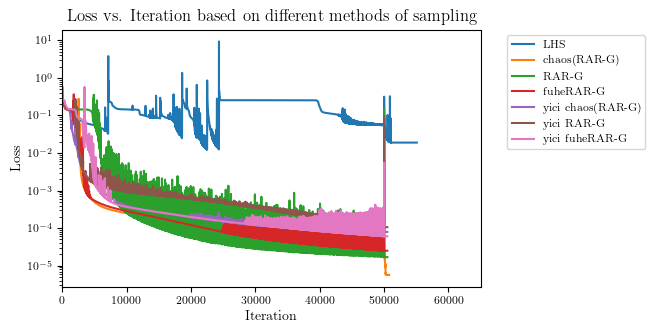

In [38]:
# 定义图例的标签
labels = ["LHS", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)", "yici RAR-G", "yici fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

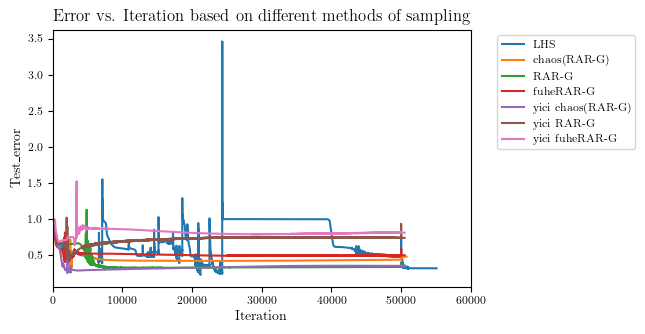

In [39]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

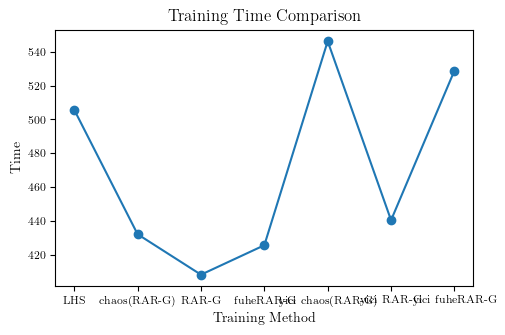

In [40]:
#绘制训练时间对比图，其中times存储了训练时间，labels存储了训练方法

# 创建一个折线图
plt.plot(labels, times, marker='o')

# 添加标题和标签
plt.title('Training Time Comparison')
plt.xlabel('Training Method')
plt.ylabel('Time')

# 显示图形
plt.show()

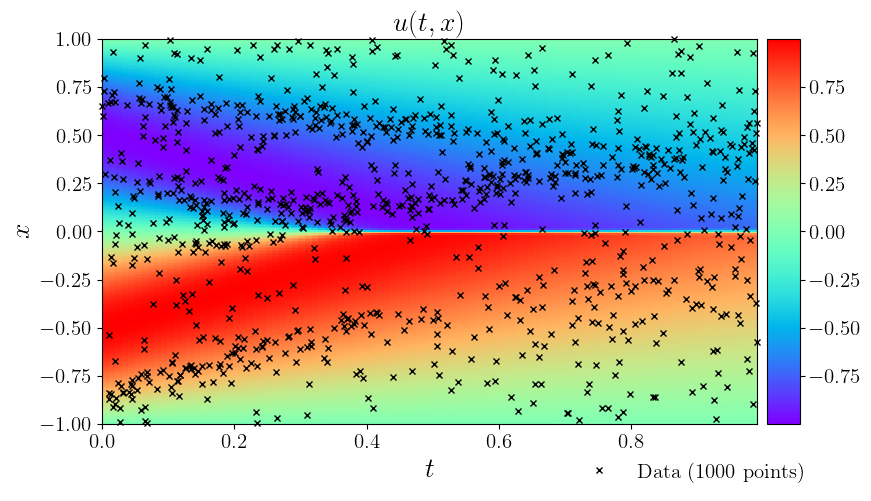

In [41]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [42]:
#表示数据集上的一组聚类，采用余弦相似度作为度量。是一个聚类群
class CosineClusters():    
    #构造函数，初始化一组聚类和一个字典来存储每个项的聚类
    def __init__(self, num_clusters=100):  #接受一个参数num_clusters，用于指定聚类的数量，默认为100
        
        self.clusters = [] # 初始化聚类列表为空列表，用于存储所有的聚类，空包含num_clusters个聚类
        self.item_cluster = {} # 初始化项聚类字典为空字典，存储每一项的聚类，键为每一项的id，值为该项所在的聚类

        # 创建初始化的聚类
        for i in range(0, num_clusters): #循环num_clusters次（聚类的数量）
            self.clusters.append(Cluster()) #将一个新的聚类添加到聚类列表中

    #聚类群方法一：按顺序将项添加到聚类中，输入参数是一组聚类items。items包含多个item（项），每个item第一个数据为文本id，第二个数据为文本。
    #依次将每一个项添加到聚类中（调用聚类方法一），当所有聚类都添加了一个项后再从第一个聚类进一步添加，直到所有项都添加到聚类中
    def add_random_training_items(self, items):
        cur_index = 0 #初始化变量cur_index为0，用于跟踪当前要添加到哪个聚类中
        for item in items: #对于items中的每一个项
            self.clusters[cur_index].add_to_cluster(item) #将当前项添加到当前索引指向的聚类中
            textid = item[0] #获取当前项的id
            self.item_cluster[textid] = self.clusters[cur_index] #将当前项的id作为键，值为当前项所在的聚类
            
            cur_index += 1 #索引加一
            if cur_index >= len(self.clusters): #如果索引超过了聚类的数量
                cur_index = 0  #将索引重置为零
    
    #聚类群方法二：目的是找到最适合给定项的聚类，输入参数是一个项item。item第一个数据为文本id，第二个数据为文本。它遍历每个聚类，并计算给定项目与每个聚类的余弦相似度。不更新聚类字典item_cluster和聚类列表clusters
    #最后返回了一个列表，第一个元素为最佳匹配的聚类（余弦相似度最高的），第二个元素最佳相似度值（余弦相似度值）。
    def get_best_cluster(self, item):
        best_cluster = None #初始化最佳聚类为空
        best_fit = float("-inf")  #初始化最佳匹配度为负无穷      
             
        for cluster in self.clusters: #对于聚类列表中的每一个聚类
            fit = cluster.cosine_similary(item) #依次计算输入项与每个聚类的余弦相似度
            if fit > best_fit: #如果当前聚类的余弦相似度大于最佳匹配度
                best_fit = fit #更新最佳匹配度为当前聚类的余弦相似度
                best_cluster = cluster #更新最佳聚类为当前聚类 
        #迭代结束后，best_cluster为与输入项最适合的聚类，best_fit为输入项的最佳匹配度

        return [best_cluster, best_fit]
    

    #聚类群方法三：将给定项添加到最适合的聚类中，输入参数是一个项item。item第一个数据为文本id，第二个数据为文本。
    #如果项已经存在于一个聚类中，它将首先从那个聚类中移除（调用聚类方法二），然后添加到最适合的聚类中（调用聚类方法一），并且更新聚类字典item_cluster。返回值是true或false，表示项目是否移动到新的聚类中
    def add_item_to_best_cluster(self, item):
        best_cluster = None #初始化最佳聚类为空
        best_fit = float("-inf") #初始化最佳匹配度为负无穷
        previous_cluster = None #初始化前一个聚类为空
        
        #如果项目已经存在于一个聚类中，则将其从那个聚类中移除
        textid = item[0] #获取输入项的id
        if textid in self.item_cluster: #如果该项的id在聚类字典item_cluster中
            previous_cluster = self.item_cluster[textid] #获取该id对应的聚类
            previous_cluster.remove_from_cluster(item) #从该聚类中移除该项

        #搜寻与该项余弦相似度最高的聚类    
        for cluster in self.clusters: #对于聚类列表中的每一个聚类
            fit = cluster.cosine_similary(item) #依次计算输入项与每个聚类的余弦相似度
            if fit > best_fit: #如果当前聚类的余弦相似度大于最佳匹配度
                best_fit = fit #更新最佳匹配度为当前聚类的余弦相似度
                best_cluster = cluster #更新最佳聚类为当前聚类
        #迭代结束后，best_cluster为与输入项最适合的聚类，best_fit为输入项的最佳匹配度
        
        #将输入项添加到最适合的聚类中，并更新聚类字典item_cluster中
        best_cluster.add_to_cluster(item) #将输入项添加到最适合的聚类中
        self.item_cluster[textid] = best_cluster #将该项对应的聚类更新为最适合的聚类
        
        #检查输入项是否移动到了新的聚类中，如果不是，则返回False；如果是，则返回True
        if best_cluster == previous_cluster:
            return False
        else:
            return True
        

    #聚类群方法四：将多个项item添加到最佳聚类中，输入参数是输入参数是一组聚类items。items包含多个item（项），每个item第一个数据为文本id，第二个数据为文本。
    #它遍历每个项item，并将其添加到最适合的聚类中（调用聚类群方法四）。最后返回的是一个数值，表示添加到新聚类中的项的数量
    def add_items_to_best_cluster(self, items):
        added = 0 #初始化变量added为0，用于追踪已经成功添加到聚类中的项的数量
        for item in items: #对于items中的每一个项
            new = self.add_item_to_best_cluster(item) #依次将当前项添加到最适合的聚类中，返回值是true或false，表示项目是否移动到新的聚类中
            if new: #如果项目移动到了新的聚类中，则将added加一
                added += 1 
                
        return added 





#一个聚类
class Cluster():
    def __init__(self):
        self.members = {} # 空字典，此聚类中每个项的id，其中键是点的ID，值是每个点，值是一个列表，列表第一个元素为点的id，第二、三个元素为点的x坐标和t坐标
        self.feature_vector = [] # 空列表，此聚类的特征向量；包含多个元素，每个元素对应一个点，是一个列表，列表第一个和第二个元素代表x坐标和t坐标
    

    #将新的项添加到聚类中的函数，接受的item是一个项，第一个元素代表文本id，第二个元素代表文本
    #假如调用add_to_cluster([1, 'Hello, World! Hello, Python!'])，则1为文本id，'Hello, World! Hello, Python!'为文本；之后feature_idx将变为{'Hello,': 0, 'World!': 1, 'Python!': 2}；
    #members将变为{1: [1, 'Hello, World! Hello, Python!']}；feature_vector将变为[2, 1, 1]，因为文本中，'Hello,'出现了两次，'World!'和'Python!'各出现了一次

    def add_to_cluster(self, item): #接受一个参数item，是一个项，第一个元素代表文本id，第二个元素代表文本
        id = item[0] #将item的第一个元素赋值给textid
        
        self.members[id] = item #这行代码将项目添加到聚类的成员字典中，键是文本ID，值是每个项
        self.feature_vector.append(item[1:]) #这行代码将项目的特征向量添加到聚类的特征向量中               
        
    #从聚类中移除一个项，包括移除存储聚类每个项id的members，和修改存储此聚类特征向量的feature_vector中的特征的数量

    def remove_from_cluster(self, item): #接受一个参数item，是一个项，第一个元素代表文本id，第二个元素代表文本
        id = item[0] #将item的第一个元素赋值给textid
        exists = self.members.pop(id, False) #从字典members中移除键为textid的项。如果该项存在，pop方法会返回该项并将其从字典中移除，然后赋值给exists。如果该项不存在，pop方法会返回默认值False
        
        if exists: #若exists为True，也就是说该项/文本在members中存在
            for i in range(len(self.feature_vector)):
                if self.feature_vector[i][0] == id:
                    del self.feature_vector[i]
                    break #删除特征向量中的特征，特征的索引为id
    
    #计算给定项与该聚类的余弦相似度，计算方法是分别计算给定项与聚类中每一项的余弦相似度，最后取平均
    def cosine_similary(self, item):
        differences = []
        for feature in self.feature_vector:
            item_tensor = torch.FloatTensor(item[1:]) #将项（一个列表，从第二个元素开始，即去除id）转换为浮点张量，赋值给item_tensor
            cluster_tensor = torch.FloatTensor(feature) #将特征向量feature_vector转换为浮点张量，赋值给cluster_tensor
            similarity = F.cosine_similarity(item_tensor, cluster_tensor, 0) #（按行）计算两个张量的余弦相似度，赋值给similarity（按行是计算两个张量每一行之间的余弦相似度，返回一个一维张量，其中每个元素都是对应行的余弦相似度）
            differences.append(similarity)
        return torch.mean(torch.stack(differences)).item() #最后返回一个数值，是differences的平均值，也就是相似度的平均值

    #计算字典members的长度，也就是数据的数量，最后可以通过调用a.size()来获取聚类中的数据数量，这里a是一个Cluster实例
    def size(self):
        return len(self.members.keys()) #keys函数返回一个包含所有键的视图对象（不是列表或集合，但可以用在需要迭代键的地方）
        #其实相当于len(self.members)


    #计算聚类的中心，也就是聚类中的最佳项，即与聚类的余弦相似度最高的项。最后返回的是一个列表，第一个元素是中心值对应的项/语句的id，第二项为对应的项/语句，第四个元素为"cluster_centroid"，第五个元素为最佳匹配度值（一个余弦相似度值）
    def get_centroid(self):
        #首先判断members是否为空，即聚类是否存在文本语句，不存在直接返回空列表
        if len(self.members) == 0:
            return []
        
        best_item = None #初始化最佳项为空
        best_fit = float("-inf") #初始化最佳匹配度为负无穷
        
        for id in self.members.keys(): #对于聚类的每一个文本语句的id
            item = self.members[id] #获取当前项对应的文本语句的内容
            similarity = self.cosine_similary(item) #计算当前项与聚类（包含该项）的余弦相似度
            if similarity > best_fit: #如果当前项与聚类的余弦相似度大于最佳匹配度
                best_fit = similarity #更新最佳匹配度为当前项与聚类的余弦相似度
                best_item = item #更新最佳项为当前项
                
        # best_item[5] = best_fit  #将最佳匹配度的值（一个余弦相似度值）赋值给最佳项的第五个元素
                
        return best_item
    
    #计算聚类的异常值，也就是与聚类的余弦相似度最低的项。最后返回的是一个列表，第一个元素是异常值对应的项/语句的id，第二项为对应的项/语句，第四个元素为"cluster_outlier"，第五个元素为1-最大异常度值（一个余弦相似度值）
    def get_outlier(self):
        #首先判断members是否为空，即聚类是否存在文本语句，不存在直接返回空列表
        if len(self.members) == 0:
            return []
        
        best_item = None #初始化最佳项为空
        biggest_outlier = float("inf") #初始化最大异常度为负无穷
        
        for id in self.members.keys(): #对于聚类的每一个文本语句的id
            item = self.members[id] #获取当前项对应的文本语句的内容
            similarity = self.cosine_similary(item) #计算当前项与聚类（包含该项）的余弦相似度
            if similarity < biggest_outlier: #如果当前项与聚类的余弦相似度小于最佳匹配度
                biggest_outlier = similarity #更新最大异常度为当前项与聚类的余弦相似度
                best_item = item #更新最佳项为当前项

        # best_item[5] = biggest_outlier #将最大异常度的值（一个余弦相似度值）赋值给最佳项的第五个元素
                
        return best_item


In [43]:
#新RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中相似度最低的10个点添加到训练点中；最后总共有1000个点，共训练50000次

#一.首先训练500次
#1.获得数据样本
resampled_points = [] #初始化一个列表，用于存储所有的配位点

num_iter = 50 #迭代次数

#总共采样10000个点
N_f_1 = 10000
X_f_train = lb + (ub-lb)*lhs(2, N_f_1) #总训练点


# 为每个训练数据点添加ID、x坐标、t坐标、残差和混沌度，最后一个为相似度（可选）
# X_f_train_id = [[i, x[0], x[1], 0, 0, 0] for i, x in enumerate(X_f_train)]
X_f_train_id = [[i, x[0], x[1]] for i, x in enumerate(X_f_train)] #总训练数据，是一个长列表，列表每个元素也是一个列表，对应一个点的所有性质，第一个元素是id，第二个元素是x坐标，第三个元素是t坐标，第四个元素是混沌度，第五个元素是残差


# #2.随机选择10个点作为初始训练数据并训练模型
# labeled_data = random.sample(X_f_train_id, 10) #随机选择10个点，labeled_data表示已经训练的数据

# # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
# X_f_train_new = np.array([[point[1], point[2]] for point in labeled_data])




data_Cluster = CosineClusters() #初始化一个Cluster类，已经训练的数据的聚类

# for i in range(len(X_f_train_id)): #遍历X_f_train_id
#     data_Cluster.add_to_cluster(X_f_train_id[i]) #将X_f_train_id的每个元素添加到a中

data_Cluster.add_random_training_items(X_f_train_id) #将X_f_train_id的每个元素添加到a中

In [44]:
print(data_Cluster.clusters[0].members) #打印第一个聚类的数据数量
print(data_Cluster.clusters[0].feature_vector) #打印第二个聚类的数据数量
print(X_f_train_id[200])

{0: [0, -0.60966425267944, 0.622975036648313], 100: [100, -0.9027143722249121, 0.14517631905244746], 200: [200, -0.5632669276197965, 0.6635282967566026], 300: [300, -0.5381401308484572, 0.9783379963743862], 400: [400, 0.5469437828696229, 0.34732124007312176], 500: [500, -0.2692400189020976, 0.529696602459576], 600: [600, 0.894296248312898, 0.39479727430372774], 700: [700, -0.6709879086960504, 0.018768105184522738], 800: [800, -0.40567087840109595, 0.4325875662987933], 900: [900, -0.5731728247971353, 0.4570318009971113], 1000: [1000, -0.4712992940429772, 0.6695888336810051], 1100: [1100, -0.690284985561564, 0.3388501467566571], 1200: [1200, -0.5551229070574759, 0.1409028097953305], 1300: [1300, 0.7390077223558622, 0.7848975051288635], 1400: [1400, -0.17142327193330587, 0.841309909482867], 1500: [1500, 0.24053785347445888, 0.2902821278130589], 1600: [1600, -0.2557369921232765, 0.4705738904108577], 1700: [1700, 0.288987432792577, 0.5531696541038579], 1800: [1800, 0.044205082750844005, 0.5

In [45]:
data_Cluster.clusters[0].remove_from_cluster(X_f_train_id[200]) #将第一个元素从第一个聚类中移除

In [46]:
a = data_Cluster.add_items_to_best_cluster(X_f_train_id)

print(a)

9879


In [47]:
print(data_Cluster.clusters[10].members) #打印第一个聚类的数据数量
print(data_Cluster.clusters[10].feature_vector) 

{}
[[0.1834579370106777, 0.42876736582132974], [0.6097013359202088, 0.2158511630510128], [-0.8364784731751744, 0.9283254091657593], [0.04800542018688314, 0.9430939954679679], [0.1587688396541691, 0.34129998245184345], [-0.24537675038383522, 0.317543038426625], [-0.007847763850373224, 0.6800294153009498], [0.1446063292600086, 0.5634452920348857], [-0.3056494143822559, 0.7442780813569969], [0.21811384893653396, 0.08894472564831217], [-0.1442878247388658, 0.35716574417454744], [0.23843407579435993, 0.6355739950084369], [-0.9039657036290757, 0.6707309448944865], [-0.4751101262715437, 0.8695279920316171], [0.7124502644599207, 0.9435713779501869], [-0.39624226876961444, 0.8125200560782411], [0.7767196747225131, 0.4415364364747584], [0.8180820141738852, 0.19067450648208492], [0.5154962533139267, 0.5302182295086532], [0.9844083260692322, 0.7913856386628588], [-0.8082360460029714, 0.8489790013961032], [0.07990494938211978, 0.1251135336978953], [0.26596044911598793, 0.45056375934184656], [-0.765

In [48]:
print(data_Cluster.clusters[0].get_centroid()) #打印第一个聚类的数据数量

[]


In [49]:
a=data_Cluster.get_best_cluster(X_f_train_id[0]) #计算X_f_train_id的第一个元素的最佳匹配聚类
print(a)

[<__main__.Cluster object at 0x000002091CA60B20>, 0.9283837080001831]


In [50]:
a=data_Cluster.clusters[0].size()
print(a) #打印第一个聚类的数据数量

0


In [51]:
# print(data_Cluster.feature_vector)
# print(data_Cluster.members)
# print(data_Cluster.size())

print(data_Cluster.clusters)
print(data_Cluster.item_cluster)

print(len(data_Cluster.clusters))
print(data_Cluster.clusters[0])

[<__main__.Cluster object at 0x00000205747109A0>, <__main__.Cluster object at 0x000002057436F820>, <__main__.Cluster object at 0x000002057436D750>, <__main__.Cluster object at 0x000002057436C5E0>, <__main__.Cluster object at 0x000002091CA48970>, <__main__.Cluster object at 0x0000020574EC0970>, <__main__.Cluster object at 0x0000020574EC0D30>, <__main__.Cluster object at 0x000002056553AEC0>, <__main__.Cluster object at 0x000002091CA60190>, <__main__.Cluster object at 0x000002091CA635B0>, <__main__.Cluster object at 0x000002091CA637C0>, <__main__.Cluster object at 0x000002091CA61270>, <__main__.Cluster object at 0x000002091CA611B0>, <__main__.Cluster object at 0x000002091CA62260>, <__main__.Cluster object at 0x000002091CA60B20>, <__main__.Cluster object at 0x000002091CA61F30>, <__main__.Cluster object at 0x000002091CA60610>, <__main__.Cluster object at 0x000002091CA620E0>, <__main__.Cluster object at 0x000002091CA60EE0>, <__main__.Cluster object at 0x000002091CA62C50>, <__main__.Cluster o

In [52]:
a=data_Cluster.get_centroid()
print(a)
b=data_Cluster.get_outlier()
print(b)



AttributeError: 'CosineClusters' object has no attribute 'get_centroid'

In [ ]:
print(data_Cluster.clusters[10].feature_vector)
print(len(data_Cluster.clusters[10].feature_vector))
print()random.choice(data_Cluster.clusters[10].feature_vector)

[[-0.8699987679552565, 0.7418553092265139], [0.06252708549842412, 0.02880886035067633], [-0.8516902994428679, 0.2052207095053542], [0.9775793000917816, 0.8317908840318661], [-0.6487532217359013, 0.43268888042478915], [-0.016363800560018738, 0.7485548420137544], [0.5440325861992459, 0.9385599098387213], [-0.7244398894490609, 0.9222188506234396], [0.7752624828249763, 0.9886807071210408], [0.7665702837013788, 0.8495079992340691], [0.17106143410212882, 0.05874545630479617], [-0.5753838389683408, 0.31423079927162606], [0.7831222427856699, 0.2837665133460011], [0.8434557757423427, 0.12954548672720512], [0.9864981326993698, 0.5648358405298849], [0.001253797478162788, 0.103122935478934], [-0.3976028779376799, 0.007343303319553378], [-0.04601240046065469, 0.741177799289334], [-0.040425888133494126, 0.06092591993577427], [-0.7421098765493485, 0.45977290717612473], [-0.727987021788935, 0.3287325919646826], [0.9618346813524457, 0.7815280291925449], [-0.8261543303058524, 0.6056269172169003], [0.997

In [ ]:
a = lb + (ub-lb)*lhs(2, N_f_1)

print(a)

data = random.choice(data_Cluster.clusters[0].feature_vector)
for i in range(1,100):
    data = np.vstack((data, np.array(random.choice(data_Cluster.clusters[i].feature_vector)) ) )
print(data)
print(len(data))


[[ 0.279966    0.5214045 ]
 [-0.0196371   0.7455052 ]
 [-0.48732935  0.23884442]
 ...
 [-0.56582441  0.49055702]
 [ 0.02793962  0.44984117]
 [ 0.69218367  0.7543741 ]]
[[-7.24624943e-01  5.50540418e-01]
 [ 8.59247860e-01  1.65830172e-01]
 [-6.95744949e-02  7.61143258e-01]
 [ 8.04101901e-01  7.46221207e-02]
 [-4.80664578e-01  5.82308255e-02]
 [-4.09838018e-01  1.74816197e-01]
 [ 4.85803501e-01  9.33514068e-01]
 [-6.43705695e-01  2.03233166e-01]
 [-7.74105602e-01  6.22289428e-01]
 [-3.57671860e-01  8.49808864e-01]
 [-7.88632868e-01  8.05769939e-01]
 [ 4.05165354e-01  7.54552551e-01]
 [-2.07149373e-01  7.89891496e-01]
 [-3.21673254e-01  6.13734431e-01]
 [ 4.36935680e-01  5.34511750e-01]
 [ 1.10469174e-01  7.99475512e-01]
 [-1.71991405e-01  2.52998284e-01]
 [ 8.28676679e-01  7.01184807e-01]
 [ 6.68168560e-02  5.93118117e-01]
 [-7.63444670e-01  4.73809491e-01]
 [ 5.90346675e-01  3.41154896e-01]
 [ 4.34355191e-01  3.95094019e-01]
 [ 1.00319528e-01  4.93523894e-01]
 [-6.38784556e-01  9.712177

In [53]:
#新chaos-based RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中混沌度最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = lb + (ub-lb)*lhs(2, N_f_1)

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代

    #重新采样100个点，基于聚类
    X_f_train_new = random.choice(data_Cluster.clusters[0].feature_vector)
    for i in range(1,100):
        X_f_train_new = np.vstack((X_f_train_new, np.array(random.choice(data_Cluster.clusters[i].feature_vector)) ) )


    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(distances, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并


    


    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    

    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500次
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 130.34it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 116.05it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 118.24it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 118.00it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 116.71it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 112.85it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 115.24it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 114.88it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 115.15it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 115.39it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 117.96it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 116.04it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████

Training time: 457.3336
Error u: 6.671566e-01


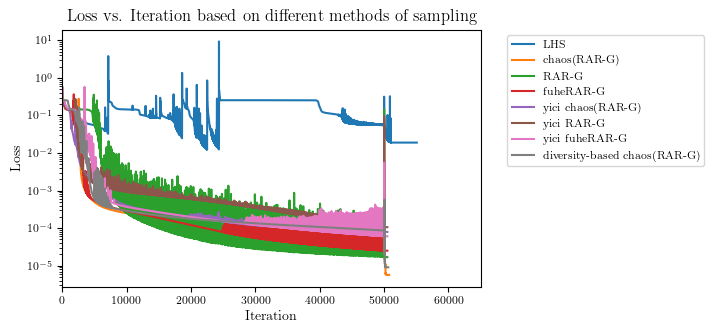

In [54]:
# 定义图例的标签
labels = ["LHS", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)", "yici RAR-G", "yici fuheRAR-G", "diversity-based chaos(RAR-G)"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

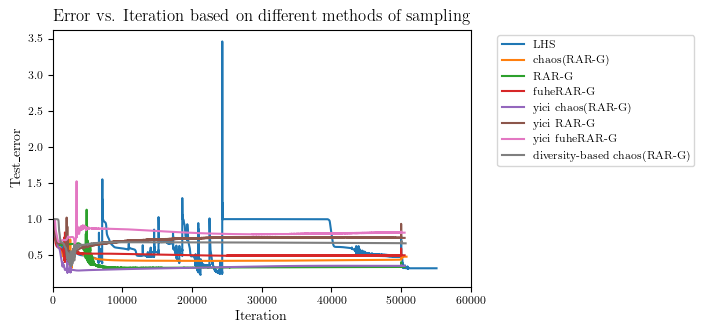

In [55]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

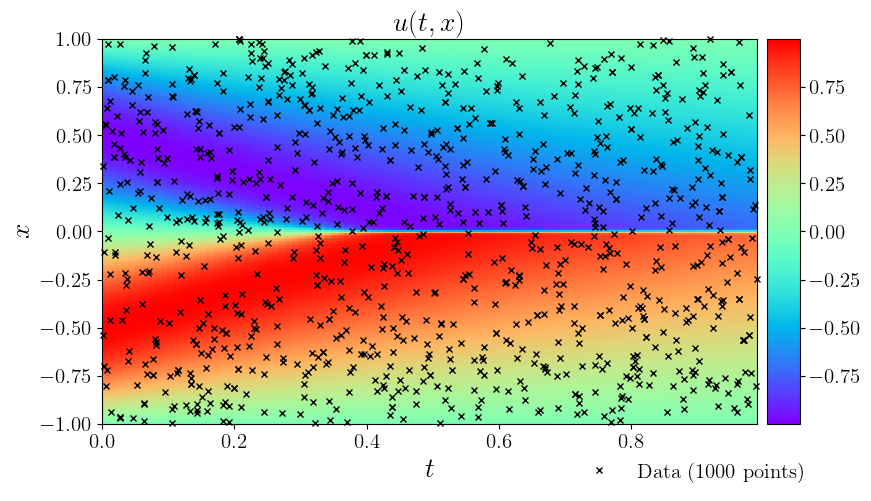

In [56]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [57]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# 在开始训练之前，创建一个空列表来保存重采样的点
resampled_points = []


#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = lb + (ub-lb)*lhs(2, N_f_1)

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代
    #重新采样100个点，基于聚类
    X_f_train_new = random.choice(data_Cluster.clusters[0].feature_vector)
    for i in range(1,100):
        X_f_train_new = np.vstack((X_f_train_new, np.array(random.choice(data_Cluster.clusters[i].feature_vector)) ) )


    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()

    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(abs_residual, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并



    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中



    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 126.33it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 122.04it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 122.40it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 123.09it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 122.50it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 123.56it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 121.51it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 122.94it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 124.23it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 121.18it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 118.95it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 118.76it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████

Training time: 429.2834
Error u: 6.221026e-01


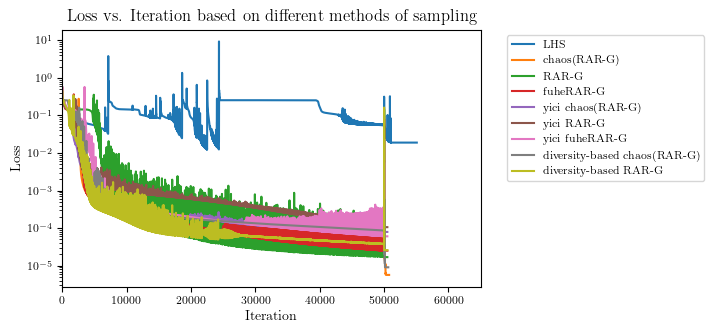

In [58]:
# 定义图例的标签
labels = ["LHS", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)", "yici RAR-G", "yici fuheRAR-G", "diversity-based chaos(RAR-G)", "diversity-based RAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

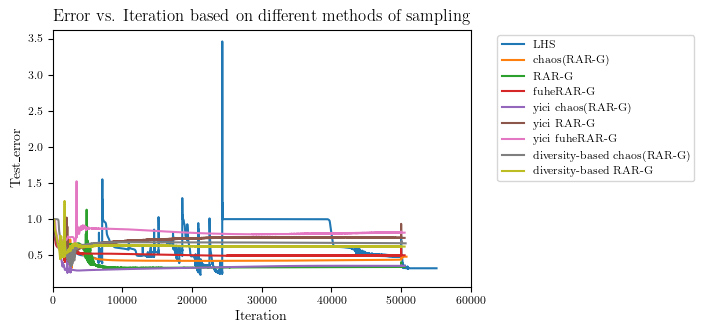

In [59]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

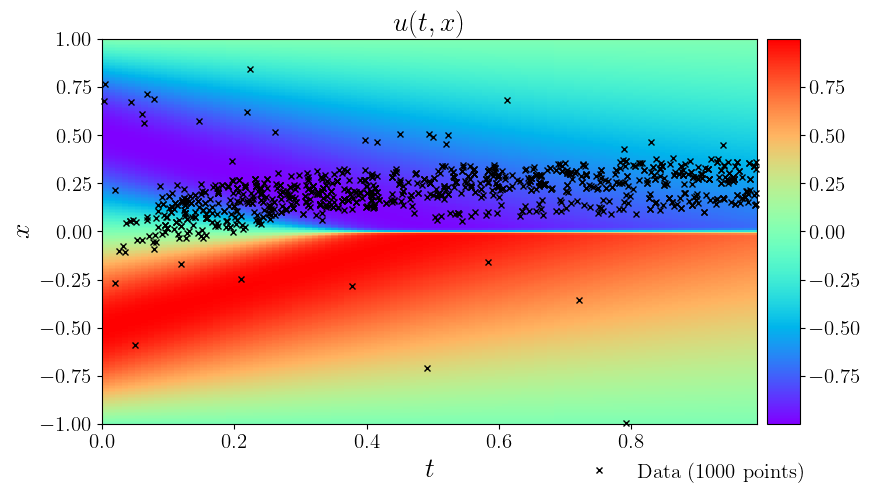

In [60]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [61]:
#fuheRAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中混沌度最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次

resampled_points = [] #初始化一个列表，用于存储所有的配位点

num_iter = 50 #迭代次数

#先训练500次
#采样配位点10个
N_f_1 = 10
X_f_train = lb + (ub-lb)*lhs(2, N_f_1)

#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500,0)


#训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
for iter in range(501, 50001, 500): #每500次迭代
    #重新采样100个点，基于聚类
    X_f_train_new = random.choice(data_Cluster.clusters[0].feature_vector)
    for i in range(1,100):
        X_f_train_new = np.vstack((X_f_train_new, np.array(random.choice(data_Cluster.clusters[i].feature_vector)) ) )

    #计算混沌情况
    #对于所有的采样点
    x0 = X_f_train_new[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X_f_train_new[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    _, residual = model.predict(X_f_train_new)

    # 计算残差的绝对值
    abs_residual = np.abs(residual)
    #将二维数组转换为一维数组
    abs_residual = abs_residual.flatten()


    # 对distances进行归一化
    distances = distances / np.linalg.norm(distances)

    # 对abs_residual进行归一化
    abs_residual = abs_residual / np.linalg.norm(abs_residual)

    # 计算信息量
    xinxi = distances * abs_residual


    # 找出绝对值最大的10个值的索引
    topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

    # 使用这些索引来提取对应的数据
    X_f_train_topk = X_f_train_new[topk_indices]

    X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并






    # 将这些点添加到训练数据中
    resampled_points.append(X_f_train) #将这些点添加到resampled_points中





    # 更新模型中的X_f_train数据
    model.X_f = X_f_train

    # 在更新数据后的模型上进行训练500次
    model.train(500,0)

model.train(0,500) #使用LBFGS训练500
#所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time

times.append(elapsed) #将训练时间添加到times列表中
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

# 训练结束后，再次使用模型进行预测，并计算误差
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) 

#将训练损失值添加到trainloss列表中
trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
#将测试误差值添加到testerror列表中
testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

SGD: 100%|██████████| 500/500 [00:03<00:00, 141.59it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 138.42it/s]
LBFGS: 0it [00:00, ?it/s]
C:\Users\lcy\AppData\Local\Temp\ipykernel_398896\1968924551.py:82: RuntimeWarning: invalid value encountered in divide
  distances = distances / np.linalg.norm(distances)
SGD: 100%|██████████| 500/500 [00:03<00:00, 138.86it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 136.63it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 138.19it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:03<00:00, 130.14it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 123.00it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 122.04it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 119.56it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%|██████████| 500/500 [00:04<00:00, 121.05it/s]
LBFGS: 0it [00:00, ?it/s]
SGD: 100%

Training time: 442.3929
Error u: 4.432003e-01


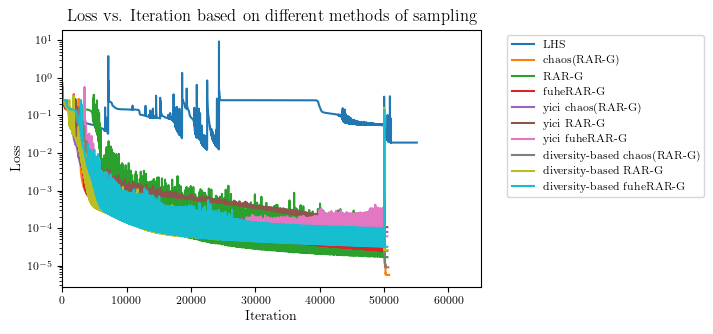

In [62]:
# 定义图例的标签
labels = ["LHS", "chaos(RAR-G)","RAR-G","fuheRAR-G", "yici chaos(RAR-G)", "yici RAR-G", "yici fuheRAR-G", "diversity-based chaos(RAR-G)", "diversity-based RAR-G", "diversity-based fuheRAR-G"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,65000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

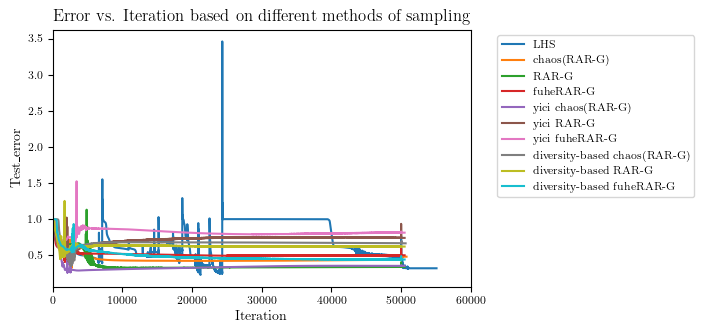

In [63]:
# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(testerror, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,60000]) # 设置x轴的范围

plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Test_error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

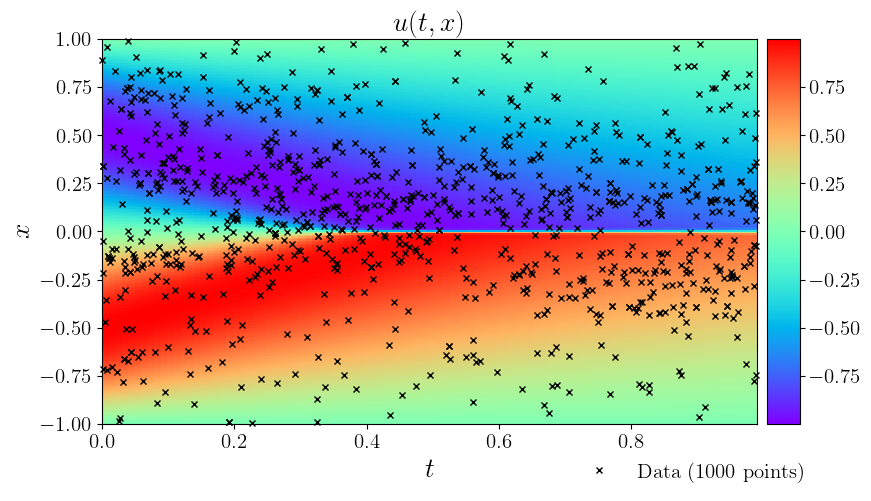

In [64]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [65]:
# #新RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中相似度最低的10个点添加到训练点中；最后总共有1000个点，共训练50000次

# #一.首先训练500次
# #1.获得数据样本
# resampled_points = [] #初始化一个列表，用于存储所有的配位点

# num_iter = 50 #迭代次数

# #总共采样10000个点
# N_f_1 = 10000
# X_f_train = lb + (ub-lb)*lhs(2, N_f_1) #总训练点


# # 为每个训练数据点添加ID、x坐标、t坐标、残差和混沌度，最后一个为相似度（可选）
# # X_f_train_id = [[i, x[0], x[1], 0, 0, 0] for i, x in enumerate(X_f_train)]
# X_f_train_id = [[i, x[0], x[1], 0, 0] for i, x in enumerate(X_f_train)] #总训练数据，是一个长列表，列表每个元素也是一个列表，对应一个点的所有性质，第一个元素是id，第二个元素是x坐标，第三个元素是t坐标，第四个元素是混沌度，第五个元素是残差


# #2.随机选择10个点作为初始训练数据并训练模型
# labeled_data = random.sample(X_f_train_id, 10) #随机选择10个点，labeled_data表示已经训练的数据

# # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
# X_f_train_new = np.array([[point[1], point[2]] for point in labeled_data])

# # 将这些点添加到训练数据中用于绘图
# resampled_points.append(X_f_train_new) #将这些点添加到resampled_points中

# #创建PINN模型并输入各种参数     
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train_new, layers, lb, ub, nu, X_star, u_star)

# #获取当前时间并赋值给start_time  
# start_time = time.time()   
# #开始训练模型            
# model.train(500,0)

# #计算混沌情况
# #对于所有的采样点
# x0 = np.array([[point[1]] for point in labeled_data])
# t0 = np.array([[point[2]] for point in labeled_data])
# # 利用x0和t0计算x{t}和t{t}，存储在xs中
# xs = [] #初始化xs
# x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
# x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
# t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

# for i in range(num_iter): #循环num_iter次
#     x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     xs.append([x,t]) #将x的数据添加到xs中
# #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


# # 给所有采样点加上一个很小的扰动
# x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
# t1 = t0 + np.random.normal(0, 0.0001)
# # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
# xs1 = [] #初始化xs1
# x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
# x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
# t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

# for i in range(num_iter): #循环num_iter次
#     x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#     xs1.append([x,t]) #将x的数据添加到xs1中
# #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

# # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
# last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
# last_iter_xs1 = np.array(xs1[-1])
# #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

# # 计算这两个点的欧氏距离
# distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
# #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上


# distances = distances.flatten()


# # 对distances进行归一化
# distances = distances / (np.linalg.norm(distances) + 1e-8)

# _, residual = model.predict(X_f_train)

# # 计算残差的绝对值
# abs_residual = np.abs(residual)
# #将二维数组转换为一维数组
# abs_residual = abs_residual.flatten()

# # 对abs_residual进行归一化
# abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)


# #更新label_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
# # 遍历labeled_data和distances/混沌度
# for point, chaos in zip(labeled_data, distances):
#     # 更新到labeled_data中
#     point[3] = chaos
# # 遍历labeled_data和残差
# for point, residual in zip(labeled_data, abs_residual):
#     # 更新到labeled_data中
#     point[4] = residual


# # 从X_f_train_id中删除labeled_data，这样保证X_f_train_id中的点都是未标记的点
# labeled_ids = [point[0] for point in labeled_data]  # 获取已标记数据的ID
# X_f_train_id = [point for point in X_f_train_id if point[0] not in labeled_ids]  # 保留那些ID不在labeled_ids中的点


# trained_data_Cluster = Cluster() #初始化一个Cluster类，已经训练的数据的聚类

# for i in range(len(labeled_data)): #遍历X_f_train_id
#     trained_data_Cluster.add_to_cluster(labeled_data[i]) #将X_f_train_id的每个元素添加到a中


# #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
# for iter in range(501, 50001, 500): #每500次迭代
#     #1.重新采样100个点作为未标记数据，计算未标记数据的性质：残差+混沌度
#     N_new = 100 #重新采样100个点
#     # 生成新的X_f_train数据
#     unlabeled_data = random.sample(X_f_train_id, N_new) #再选择100个点

#     # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
#     X_f_train_new = np.array([[point[1], point[2]] for point in unlabeled_data])
#     #对于所有的采样点
#     x0 = np.array([[point[1]] for point in labeled_data])
#     t0 = np.array([[point[2]] for point in labeled_data])
#     # 利用x0和t0计算x{t}和t{t}，存储在xs中
#     xs = [] #初始化xs
#     x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         xs.append([x,t]) #将x的数据添加到xs中
#     #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果
#     # 给所有采样点加上一个很小的扰动
#     x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
#     t1 = t0 + np.random.normal(0, 0.0001)
#     # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
#     xs1 = [] #初始化xs1
#     x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#         xs1.append([x,t]) #将x的数据添加到xs1中
#     #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

#     # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
#     last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
#     last_iter_xs1 = np.array(xs1[-1])
#     #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数
#     # 计算这两个点的欧氏距离
#     distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
#     #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上
#     distances = distances.flatten()
#     # 对distances进行归一化
#     distances = distances / (np.linalg.norm(distances) + 1e-8)

#     _, residual = model.predict(X_f_train)
#     # 计算残差的绝对值
#     abs_residual = np.abs(residual)
#     #将二维数组转换为一维数组
#     abs_residual = abs_residual.flatten()
#     # 对abs_residual进行归一化
#     abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)



#     #2.更新unlabel_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
#     # 遍历unlabeled_data和distances/混沌度
#     for point, chaos in zip(unlabeled_data, distances):
#         # 更新到labeled_data中
#         point[3] = chaos
#     # 遍历labeled_data和残差
#     for point, residual in zip(unlabeled_data, abs_residual):
#         # 更新到labeled_data中
#         point[4] = residual


#     #3.比较unlabeled_data和trained_data_Cluster聚类的关系，从中选出十个相似度最低的点
#     unlabeled_data_xiangsidu = [] #初始化一个列表，用于存储unlabeled_data和trained_data_Cluster聚类的相似度
#     for item in unlabeled_data:
#         unlabeled_data_xiangsidu.append(trained_data_Cluster.cosine_similary(item)) #计算unlabeled_data和trained_data_Cluster聚类的相似度
#     # 将unlabeled_data和unlabeled_data_xiangsidu打包在一起
#     data_with_similarity = list(zip(unlabeled_data, unlabeled_data_xiangsidu))
#     # 按照相似度排序
#     sorted_data = sorted(data_with_similarity, key=lambda x: x[1])
#     # 选择相似度最低的10个数据
#     selected_data = [data for data, similarity in sorted_data[:10]]


#     #4.从X_f_train_id中删除selected_data，这样保证X_f_train_id中的点都是未标记的点
#     selected_ids = [point[0] for point in selected_data]  # 获取已标记数据的ID
#     X_f_train_id = [point for point in X_f_train_id if point[0] not in selected_ids]  # 保留那些ID不在labeled_ids中的点



#     #5.将选出来的点与labeled_data合并，得到新的训练数据
#     labeled_data = list(trained_data_Cluster.members.values()) #从聚类中获取已标记数据
#     # 将selected_data添加到labeled_data的末尾
#     labeled_data.extend(selected_data)






#     #6.使用新的训练数据进行训练
#     # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
#     X_f_train_new = np.array([[point[1], point[2]] for point in labeled_data])

#     # 将这些点添加到训练数据中
#     resampled_points.append(X_f_train_new) #将这些点添加到resampled_points中

#     # 更新模型中的X_f_train数据
#     model.X_f = X_f_train_new
#     #开始训练模型            
#     model.train(500,0)

#     #7.更新这些点的混沌度和残差(因为模型训练过了)
#     #计算混沌情况
#     #对于所有的采样点
#     x0 = np.array([[point[1]] for point in labeled_data])
#     t0 = np.array([[point[2]] for point in labeled_data])
#     # 利用x0和t0计算x{t}和t{t}，存储在xs中
#     xs = [] #初始化xs
#     x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         xs.append([x,t]) #将x的数据添加到xs中
#     #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


#     # 给所有采样点加上一个很小的扰动
#     x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
#     t1 = t0 + np.random.normal(0, 0.0001)
#     # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
#     xs1 = [] #初始化xs1
#     x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#         xs1.append([x,t]) #将x的数据添加到xs1中
#     #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

#     # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
#     last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
#     last_iter_xs1 = np.array(xs1[-1])
#     #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

#     # 计算这两个点的欧氏距离
#     distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
#     #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

#     distances = distances.flatten()

#     # 对distances进行归一化
#     distances = distances / (np.linalg.norm(distances) + 1e-8)

#     #计算残差
#     _, residual = model.predict(X_f_train)

#     # 计算残差的绝对值
#     abs_residual = np.abs(residual)
#     #将二维数组转换为一维数组
#     abs_residual = abs_residual.flatten()


#     # 对abs_residual进行归一化
#     abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)


#     #更新label_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
#     # 遍历labeled_data和distances/混沌度
#     for point, chaos in zip(labeled_data, distances):
#         # 更新到labeled_data中
#         point[3] = chaos
#     # 遍历labeled_data和残差
#     for point, residual in zip(labeled_data, abs_residual):
#         # 更新到labeled_data中
#         point[4] = residual


#     trained_data_Cluster = Cluster() #重新初始化Cluster类，已经训练的数据的聚类，因为之前的已经训练的数据已经被覆盖

#     for i in range(len(labeled_data)): #遍历X_f_train_id
#         trained_data_Cluster.add_to_cluster(labeled_data[i]) #将X_f_train_id的每个元素添加到a中

# #迭代结束后，使用LBFGS训练500
# model.train(0,500) #使用LBFGS训练500
# #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
# elapsed = time.time() - start_time
# #打印训练所花时间                
# print('Training time: %.4f' % (elapsed))

# # 训练结束后，再次使用模型进行预测，并计算误差
# u_pred, f_pred = model.predict(X_star)
# error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# print('Error u: %e' % (error_u)) 

# #将训练损失值添加到trainloss列表中
# trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
# #将测试误差值添加到testerror列表中
# testerror.append(torch.stack(model.test_error).cpu().detach().numpy())


In [66]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlim([0,60000]) # 设置x轴的范围
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Loss') # 设置y轴的标签
# plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [67]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(testerror, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# plt.xlim([0,60000]) # 设置x轴的范围

# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Test_error') # 设置y轴的标签
# plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [68]:
# # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
# X_f_train = np.array([[point[1], point[2]] for point in labeled_data])


# data = scipy.io.loadmat('../data/burgers_shock.mat')
# #从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
# #生成一个二位网络，X和T是输出的二维数组
# #这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
# X, T = np.meshgrid(x,t)

# X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
# u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


# #使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
# U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


# ###### Row 0: u(t,x) ##################    

# fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
# ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

# #绘图的数据来源
# h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
#                                                    #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
#                                                    #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


# #添加颜色条
# divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
# cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
# cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
# cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





# #设置图的标签、图例、标题和刻度标签
# #设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
# ax.set_xlabel('$t$', size=20)
# ax.set_ylabel('$x$', size=20)
# #设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
# #设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
# ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
# ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


# #显示图片
# plt.show() #显示所有打开的图形的函数

In [69]:
# #测试RAR-G方法，对1000个点，先选择10个点训练500次，然后每50次迭代重采样100个点，选出其中残差最大的1个点添加到训练点中；最后总共有1000个点，共训练10000次
# # 在开始训练之前，创建一个空列表来保存重采样的点
# resampled_points = []


# #先训练500次
# #采样配位点10个
# N_f_1 = 1 #每次训练添加的点
# X_f_train = lb + (ub-lb)*lhs(2, 10)

# #创建PINN模型并输入各种参数     
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

# #获取当前时间并赋值给start_time  
# start_time = time.time()   
# #开始训练模型            
# model.train(500,0)


# #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
# for iter in range(501, 50001, 50): #每500次迭代
#     N_f_new = 100 #重新采样100个点
#     # 生成新的X_f_train数据
#     X_f_train_new = lb + (ub-lb)*lhs(2, N_f_new)

#     _, residual = model.predict(X_f_train_new)

#     # 计算残差的绝对值
#     abs_residual = np.abs(residual)
#     #将二维数组转换为一维数组
#     abs_residual = abs_residual.flatten()

#     # 找出绝对值最大的10个值的索引
#     topk_indices = np.argpartition(abs_residual, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

#     # 使用这些索引来提取对应的数据
#     X_f_train_topk = X_f_train_new[topk_indices]

#     X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并



#     # 将这些点添加到训练数据中
#     resampled_points.append(X_f_train) #将这些点添加到resampled_points中



#     # 更新模型中的X_f_train数据
#     model.X_f = X_f_train

#     # 在更新数据后的模型上进行训练500次
#     model.train(50,0)

# model.train(0,500) #使用LBFGS训练500
# #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
# elapsed = time.time() - start_time
# #打印训练所花时间                
# print('Training time: %.4f' % (elapsed))

# # 训练结束后，再次使用模型进行预测，并计算误差
# u_pred, f_pred = model.predict(X_star)
# error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# print('Error u: %e' % (error_u)) 

# #将训练损失值添加到trainloss列表中
# trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
# #将测试误差值添加到testerror列表中
# testerror.append(torch.stack(model.test_error).cpu().detach().numpy())

In [70]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)","ceshi-chaos(RAR-G)","ceshi-RAR-G"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlim([0,60000]) # 设置x轴的范围
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Loss') # 设置y轴的标签
# plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [71]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)","ceshi-chaos(RAR-G)","ceshi-RAR-G"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(testerror, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# plt.xlim([0,60000]) # 设置x轴的范围

# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Test_error') # 设置y轴的标签
# plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [72]:

# data = scipy.io.loadmat('../data/burgers_shock.mat')
# #从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
# #生成一个二位网络，X和T是输出的二维数组
# #这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
# X, T = np.meshgrid(x,t)

# X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
# u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


# #使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
# U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


# ###### Row 0: u(t,x) ##################    

# fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
# ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

# #绘图的数据来源
# h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
#                                                    #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
#                                                    #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


# #添加颜色条
# divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
# cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
# cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
# cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  



# #设置图的标签、图例、标题和刻度标签
# #设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
# ax.set_xlabel('$t$', size=20)
# ax.set_ylabel('$x$', size=20)
# #设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
# #设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
# ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
# ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


# #显示图片
# plt.show() #显示所有打开的图形的函数

In [73]:
# #新RAR-G方法，对1000个点，先选择10个点训练500次，然后每50次迭代重采样100个点，选出其中相似度最低的1个点添加到训练点中；最后总共有1000个点，共训练50000次

# #一.首先训练500次
# #1.获得数据样本
# resampled_points = [] #初始化一个列表，用于存储所有的配位点

# num_iter = 50 #迭代次数

# #总共采样10000个点
# N_f_1 = 10000
# X_f_train = lb + (ub-lb)*lhs(2, N_f_1) #总训练点


# # 为每个训练数据点添加ID、x坐标、t坐标、残差和混沌度，最后一个为相似度（可选）
# # X_f_train_id = [[i, x[0], x[1], 0, 0, 0] for i, x in enumerate(X_f_train)]
# X_f_train_id = [[i, x[0], x[1], 0, 0] for i, x in enumerate(X_f_train)] #总训练数据，是一个长列表，列表每个元素也是一个列表，对应一个点的所有性质，第一个元素是id，第二个元素是x坐标，第三个元素是t坐标，第四个元素是混沌度，第五个元素是残差


# #2.随机选择10个点作为初始训练数据并训练模型
# labeled_data = random.sample(X_f_train_id, 10) #随机选择10个点，labeled_data表示已经训练的数据

# # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
# X_f_train_new = np.array([[point[1], point[2]] for point in labeled_data])

# # 将这些点添加到训练数据中用于绘图
# resampled_points.append(X_f_train_new) #将这些点添加到resampled_points中

# #创建PINN模型并输入各种参数     
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train_new, layers, lb, ub, nu, X_star, u_star)

# #获取当前时间并赋值给start_time  
# start_time = time.time()   
# #开始训练模型            
# model.train(500,0)

# #计算混沌情况
# #对于所有的采样点
# x0 = np.array([[point[1]] for point in labeled_data])
# t0 = np.array([[point[2]] for point in labeled_data])
# # 利用x0和t0计算x{t}和t{t}，存储在xs中
# xs = [] #初始化xs
# x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
# x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
# t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

# for i in range(num_iter): #循环num_iter次
#     x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     xs.append([x,t]) #将x的数据添加到xs中
# #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


# # 给所有采样点加上一个很小的扰动
# x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
# t1 = t0 + np.random.normal(0, 0.0001)
# # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
# xs1 = [] #初始化xs1
# x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
# x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
# t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

# for i in range(num_iter): #循环num_iter次
#     x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#     xs1.append([x,t]) #将x的数据添加到xs1中
# #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

# # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
# last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
# last_iter_xs1 = np.array(xs1[-1])
# #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

# # 计算这两个点的欧氏距离
# distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
# #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上


# distances = distances.flatten()


# # 对distances进行归一化
# distances = distances / (np.linalg.norm(distances) + 1e-8)

# _, residual = model.predict(X_f_train)

# # 计算残差的绝对值
# abs_residual = np.abs(residual)
# #将二维数组转换为一维数组
# abs_residual = abs_residual.flatten()

# # 对abs_residual进行归一化
# abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)


# #更新label_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
# # 遍历labeled_data和distances/混沌度
# for point, chaos in zip(labeled_data, distances):
#     # 更新到labeled_data中
#     point[3] = chaos
# # 遍历labeled_data和残差
# for point, residual in zip(labeled_data, abs_residual):
#     # 更新到labeled_data中
#     point[4] = residual


# # 从X_f_train_id中删除labeled_data，这样保证X_f_train_id中的点都是未标记的点
# labeled_ids = [point[0] for point in labeled_data]  # 获取已标记数据的ID
# X_f_train_id = [point for point in X_f_train_id if point[0] not in labeled_ids]  # 保留那些ID不在labeled_ids中的点


# trained_data_Cluster = Cluster() #初始化一个Cluster类，已经训练的数据的聚类

# for i in range(len(labeled_data)): #遍历X_f_train_id
#     trained_data_Cluster.add_to_cluster(labeled_data[i]) #将X_f_train_id的每个元素添加到a中


# #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
# for iter in range(501, 50001, 50): #每500次迭代
#     #1.重新采样100个点作为未标记数据，计算未标记数据的性质：残差+混沌度
#     N_new = 100 #重新采样100个点
#     # 生成新的X_f_train数据
#     unlabeled_data = random.sample(X_f_train_id, N_new) #再选择100个点

#     # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
#     X_f_train_new = np.array([[point[1], point[2]] for point in unlabeled_data])
#     #对于所有的采样点
#     x0 = np.array([[point[1]] for point in labeled_data])
#     t0 = np.array([[point[2]] for point in labeled_data])
#     # 利用x0和t0计算x{t}和t{t}，存储在xs中
#     xs = [] #初始化xs
#     x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         xs.append([x,t]) #将x的数据添加到xs中
#     #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果
#     # 给所有采样点加上一个很小的扰动
#     x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
#     t1 = t0 + np.random.normal(0, 0.0001)
#     # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
#     xs1 = [] #初始化xs1
#     x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#         xs1.append([x,t]) #将x的数据添加到xs1中
#     #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

#     # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
#     last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
#     last_iter_xs1 = np.array(xs1[-1])
#     #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数
#     # 计算这两个点的欧氏距离
#     distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
#     #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上
#     distances = distances.flatten()
#     # 对distances进行归一化
#     distances = distances / (np.linalg.norm(distances) + 1e-8)

#     _, residual = model.predict(X_f_train)
#     # 计算残差的绝对值
#     abs_residual = np.abs(residual)
#     #将二维数组转换为一维数组
#     abs_residual = abs_residual.flatten()
#     # 对abs_residual进行归一化
#     abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)



#     #2.更新unlabel_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
#     # 遍历unlabeled_data和distances/混沌度
#     for point, chaos in zip(unlabeled_data, distances):
#         # 更新到labeled_data中
#         point[3] = chaos
#     # 遍历labeled_data和残差
#     for point, residual in zip(unlabeled_data, abs_residual):
#         # 更新到labeled_data中
#         point[4] = residual


#     #3.比较unlabeled_data和trained_data_Cluster聚类的关系，从中选出十个相似度最低的点
#     unlabeled_data_xiangsidu = [] #初始化一个列表，用于存储unlabeled_data和trained_data_Cluster聚类的相似度
#     for item in unlabeled_data:
#         unlabeled_data_xiangsidu.append(trained_data_Cluster.cosine_similary(item)) #计算unlabeled_data和trained_data_Cluster聚类的相似度
#     # 将unlabeled_data和unlabeled_data_xiangsidu打包在一起
#     data_with_similarity = list(zip(unlabeled_data, unlabeled_data_xiangsidu))
#     # 按照相似度排序
#     sorted_data = sorted(data_with_similarity, key=lambda x: x[1])
#     # 选择相似度最低的1个数据
#     selected_data = [data for data, similarity in sorted_data[:1]]


#     #4.从X_f_train_id中删除selected_data，这样保证X_f_train_id中的点都是未标记的点
#     selected_ids = [point[0] for point in selected_data]  # 获取已标记数据的ID
#     X_f_train_id = [point for point in X_f_train_id if point[0] not in selected_ids]  # 保留那些ID不在labeled_ids中的点



#     #5.将选出来的点与labeled_data合并，得到新的训练数据
#     labeled_data = list(trained_data_Cluster.members.values()) #从聚类中获取已标记数据
#     # 将selected_data添加到labeled_data的末尾
#     labeled_data.extend(selected_data)






#     #6.使用新的训练数据进行训练
#     # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
#     X_f_train_new = np.array([[point[1], point[2]] for point in labeled_data])

#     # 将这些点添加到训练数据中
#     resampled_points.append(X_f_train_new) #将这些点添加到resampled_points中

#     # 更新模型中的X_f_train数据
#     model.X_f = X_f_train_new
#     #开始训练模型            
#     model.train(50,0)

#     #7.更新这些点的混沌度和残差(因为模型训练过了)
#     #计算混沌情况
#     #对于所有的采样点
#     x0 = np.array([[point[1]] for point in labeled_data])
#     t0 = np.array([[point[2]] for point in labeled_data])
#     # 利用x0和t0计算x{t}和t{t}，存储在xs中
#     xs = [] #初始化xs
#     x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#         xs.append([x,t]) #将x的数据添加到xs中
#     #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


#     # 给所有采样点加上一个很小的扰动
#     x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
#     t1 = t0 + np.random.normal(0, 0.0001)
#     # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
#     xs1 = [] #初始化xs1
#     x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
#     x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
#     t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

#     for i in range(num_iter): #循环num_iter次
#         x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
#         x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
#         t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
#         xs1.append([x,t]) #将x的数据添加到xs1中
#     #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

#     # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
#     last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
#     last_iter_xs1 = np.array(xs1[-1])
#     #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

#     # 计算这两个点的欧氏距离
#     distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
#     #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

#     distances = distances.flatten()

#     # 对distances进行归一化
#     distances = distances / (np.linalg.norm(distances) + 1e-8)

#     #计算残差
#     _, residual = model.predict(X_f_train)

#     # 计算残差的绝对值
#     abs_residual = np.abs(residual)
#     #将二维数组转换为一维数组
#     abs_residual = abs_residual.flatten()


#     # 对abs_residual进行归一化
#     abs_residual = abs_residual / (np.linalg.norm(abs_residual) + 1e-8)


#     #更新label_data中的性质（每个训练数据的第四个数据为混沌度，第五个数据为残差绝对值）
#     # 遍历labeled_data和distances/混沌度
#     for point, chaos in zip(labeled_data, distances):
#         # 更新到labeled_data中
#         point[3] = chaos
#     # 遍历labeled_data和残差
#     for point, residual in zip(labeled_data, abs_residual):
#         # 更新到labeled_data中
#         point[4] = residual


#     trained_data_Cluster = Cluster() #重新初始化Cluster类，已经训练的数据的聚类，因为之前的已经训练的数据已经被覆盖

#     for i in range(len(labeled_data)): #遍历X_f_train_id
#         trained_data_Cluster.add_to_cluster(labeled_data[i]) #将X_f_train_id的每个元素添加到a中

# #迭代结束后，使用LBFGS训练500
# model.train(0,500) #使用LBFGS训练500
# #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
# elapsed = time.time() - start_time
# #打印训练所花时间                
# print('Training time: %.4f' % (elapsed))

# # 训练结束后，再次使用模型进行预测，并计算误差
# u_pred, f_pred = model.predict(X_star)
# error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# print('Error u: %e' % (error_u)) 

# #将训练损失值添加到trainloss列表中
# trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())
# #将测试误差值添加到testerror列表中
# testerror.append(torch.stack(model.test_error).cpu().detach().numpy())


In [74]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)","ceshi-chaos(RAR-G)","ceshi-RAR-G","ceshi-xin(RAR-G)"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlim([0,60000]) # 设置x轴的范围
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Loss') # 设置y轴的标签
# plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [75]:
# # 定义图例的标签
# labels = ["LHS", "chaos(RAR-G)","RAR-G", "fuheRAR-G","xin(RAR-G)","ceshi-chaos(RAR-G)","ceshi-RAR-G","ceshi-xin(RAR-G)"]

# # 创建一个新的图形
# plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(testerror, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

# # 添加图例，放在图像外
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# plt.xlim([0,60000]) # 设置x轴的范围

# plt.xlabel('Iteration') # 设置x轴的标签
# plt.ylabel('Test_error') # 设置y轴的标签
# plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# # 显示图形
# plt.show()

In [76]:
# # 从labeled_data中提取出x坐标和t坐标，并转换为numpy数组
# X_f_train = np.array([[point[1], point[2]] for point in labeled_data])


# data = scipy.io.loadmat('../data/burgers_shock.mat')
# #从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
# t = data['t'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
# Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
# #生成一个二位网络，X和T是输出的二维数组
# #这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
# X, T = np.meshgrid(x,t)

# X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
# u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


# #使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
# U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


# ###### Row 0: u(t,x) ##################    

# fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
# ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

# #绘图的数据来源
# h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
#                                                    #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
#                                                    #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


# #添加颜色条
# divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
# cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
# cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
# cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  





# #设置图的标签、图例、标题和刻度标签
# #设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
# ax.set_xlabel('$t$', size=20)
# ax.set_ylabel('$x$', size=20)
# #设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
# #设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
# ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
# ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


# #显示图片
# plt.show() #显示所有打开的图形的函数